## Example with CNN-LSTM on live BTC close price using the full data

In [64]:
import subprocess
import sys
import warnings
import os
from IPython.display import display, HTML
os.environ["TZ"] = "UTC"
warnings.filterwarnings("ignore")

USE_COLAB = False
if USE_COLAB == True:
    from google.colab import drive
    drive.mount('/content/drive')
    work_dir = '/content/drive/MyDrive/Colab Notebooks/sats4u/'
    secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'    
else:
    work_dir = '/Users/gabrieletocci/Google Drive/My Drive/Colab Notebooks/sats4u/'
    secret_data_folder = '/Users/gabrieletocci/Google Drive/My Drive/Colab Notebooks/crypto_project/crypto_data/'
    
# if 'darwin' in sys.platform:
#     print('Running \'caffeinate\' on MacOSX to prevent the system from sleeping')
#     subprocess.Popen('caffeinate')

os.chdir(work_dir)
dir_to_save = '/Users/gabrieletocci/Documents/projects/CODE/data_sats4u/'

In [65]:
! pip install -r requirements.txt

In [66]:
import json
import pandas as pd
import numpy as np
from binance.enums import *
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.timeutils as tu
import src.sats2backtest as s2b
import re

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)


## Load Asset Details, Binance client data and Download 15m candles from Binance

In [67]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details, data_folder,verbose=False)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i',testnet=False)
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)

In [68]:
secrets_filename_test = secret_data_folder+'data_test.json'
crypto_test = lc.CryptoData(asset_details,data_folder,verbose = False)
crypto_test.load_binance_client(secrets_filename_test,data1_str = 'DATA1',data2_str = 'DATA2i',testnet=True)
crypto_test.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto_test.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df_test = crypto_test.load_cryptos(tickers,save = False)  

### Generate Candles and build features from technical analysis

In [69]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 5000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts(verbose=True)
ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)

Candles Normalized
Extracted last 5000 steps


In [ ]:
USE_PRETRAINED = True
PRESAVED_MODELDATE = "220709_08_45"

initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler ,split_fraction = 1)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = False)
loaded_model.load_scaler(model_name + '/scaler.sav')
preds = c2t.denorm(loaded_model.scaler,can_btc.candles,loaded_model.preds)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
new_time_steps = int((can_btc.candles.index[-1] - initial_timestamp)/(can_btc.candles.index[1] - can_btc.candles.index[0]))
new_time_steps

56

,Close,Pred Close
Date,,
2022-05-18 19:00:00,29288.05,29490.271454
2022-05-18 19:15:00,29239.98,29479.990227
2022-05-18 19:30:00,29272.20,29458.321419
2022-05-18 19:45:00,29276.55,29527.763074
2022-05-18 20:00:00,29152.58,29580.635619
...,...,...
2022-07-09 07:30:00,21620.00,21902.778096
2022-07-09 07:45:00,21654.72,21952.956770
2022-07-09 08:00:00,21664.46,21980.101698


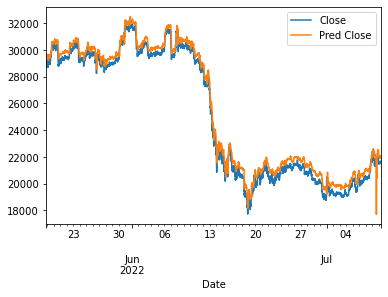

In [ ]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period =  +1)
df_preds_true.dropna().plot()
df_preds_true.dropna()

Initial time 2022-07-08 19:00:00
Final time 2022-07-09 08:30:00
Fee: 0.025
----------------------
Buy      30 ( 16 ok 14 ko )
Avg PCT gain: 1.0028252487879648
Avg PCT loss: 0.9974752764014233
Wins  PCT   0.5333333333333333
Avg PCT Gain.    1.0028252487879648
No-op    0
Wallet   168.33149999999637
Drawback -202.22225000000088
Kelly Fraction    0.06915628665120888
Total earned 168.33149999999637


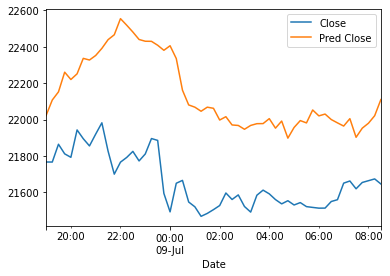

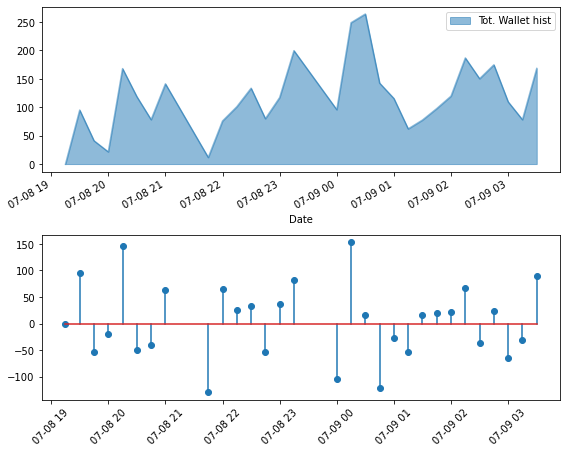

In [ ]:
if new_time_steps > 20 :
    df_preds_true.iloc[-new_time_steps:].dropna().plot()

    wallet_hist_df, wallet, kelly_frac = s2b.backtest_df(df_preds_true.iloc[-new_time_steps:].dropna(), step_back=+ 2,
                                                    long_short = "long", fee=0.025, cutoff_long = 20. ,cutoff_short = 20.0)
    s2b.show_backtest_results(wallet,wallet_hist_df)

In [ ]:
def tryexceptwait(func):
  def inner(*args,**kwargs):
        try:
          return func(*args, **kwargs)
        except:
          time.sleep(61)
          return func(*args,**kwargs)
  return inner

@tryexceptwait
def getminutedata(binance_client, ticker,interval, look_back):

  frame = pd.DataFrame(binance_client.get_historical_klines(ticker,interval, look_back + "min ago UTC"))
  frame = frame.iloc[:,:6]
  frame.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
  frame = frame.set_index("Time")
  frame.index = pd.to_datetime(frame.index,unit = "ms")
  frame = frame.astype(float)
  return frame

def print_time_status_and_sleep(prev_close_date,delta_date,dt_unit,sleep=True):

  elapsed_minutes = (pd.Timestamp(datetime.now()) -
                     prev_close_date).seconds/dt_unit
  time_condition = 1. < delta_date.seconds/dt_unit - elapsed_minutes < + 1.
  min_till_close = (delta_date.seconds/dt_unit - elapsed_minutes)
  print(f'Current Time: {pd.Timestamp(datetime.now())}')
  print(f'Minutes till Next Close: {min_till_close}')
  if sleep:
    print(f"Sleep for {min_till_close} mins.")
    time.sleep(min_till_close*dt_unit + 10)
    print(f"finished to sleep at {pd.Timestamp(datetime.now())}")


non_decimal = re.compile(r'[^\d.]+')
n_klines = crypto.kline_size
n_klines = non_decimal.sub('',n_klines)

#example: 
# a='123.f.'
# non_decimal.sub('', a )
# a='123'


In [ ]:
crypto_test.binance_client.get_account()

{'makerCommission': 0,
 'takerCommission': 0,
 'buyerCommission': 0,
 'sellerCommission': 0,
 'canTrade': True,
 'canWithdraw': False,
 'canDeposit': False,
 'updateTime': 1657355440582,
 'accountType': 'SPOT',
 'balances': [{'asset': 'BNB',
   'free': '1000.00000000',
   'locked': '0.00000000'},
  {'asset': 'BTC', 'free': '1.00600000', 'locked': '0.00000000'},
  {'asset': 'BUSD', 'free': '10000.00000000', 'locked': '0.00000000'},
  {'asset': 'ETH', 'free': '100.00000000', 'locked': '0.00000000'},
  {'asset': 'LTC', 'free': '500.00000000', 'locked': '0.00000000'},
  {'asset': 'TRX', 'free': '500000.00000000', 'locked': '0.00000000'},
  {'asset': 'USDT', 'free': '9870.75205766', 'locked': '0.00000000'},
  {'asset': 'XRP', 'free': '50000.00000000', 'locked': '0.00000000'}],
 'permissions': ['SPOT']}

In [ ]:
# print(
#     f'Current limit is {buyprice*(1+avg_change)} or close position in {str(time_until_close)}')
# print(
#     f'Current stop is {buyprice*(1-avg_change)} or close position in {str(time_until_close)}')

investment = 1000.
conservative_kelly = kelly_frac*.5
portfolio = investment
open_position = False
avg_change = 0.004
fee = 0.025
step_back = 2
cutoff_long = 20.

verbose = True

total_wallet_history = []
single_wallet_history = []
single_wallet_hist_deb = []
time_history = []
fill_order_history = []
time_fill_order_history = []
close_order_history = []

wallet = 0.
buys_cnt = 0
buys_cnt_win = 0
buys_cnt_losses = 0
drawback = 0
old_profit_negative = False
old_profits = 0
mean_pct_gain = 0
mean_pct_loss = 0

last_dates = getminutedata(
    crypto.binance_client, tickers[0], crypto.kline_size, '30').index
delta_date = last_dates[-1]-last_dates[-2]
prev_close_date = last_dates[-1]
buffer_delta = 0.1*delta_date

while True:
 
    print_time_status_and_sleep(prev_close_date, delta_date, crypto.dt,sleep = True)
    ldata_df_new = crypto.load_cryptos(tickers,save = False)
    can_btc = fb.Candles(ldata_df_new,"Bitcoin")
    can_btc.buildfeatures()
    ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 2000, step_back = 48, candle_step_str = crypto.kline_size,
                    lownorm = 0.2, upnorm= 0.8)

    ts_btc.candles2ts(verbose = False)
    ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
    ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)
    initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))
    loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler, split_fraction = 1)
    loaded_model.sats2model()
    loaded_model.load_model(model_name)
    loaded_model.sats2pred(predict_on_test=False)
    loaded_model.load_scaler(model_name + '/scaler.sav')
    preds = c2t.denorm(loaded_model.scaler, can_btc.candles, loaded_model.preds)
    df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = +1)
    df_preds_true_shifted = df_preds_true.copy()
    df_preds_true_shifted.iloc[:,0] = df_preds_true.iloc[:,0].shift(step_back,delta_date)
    prev_true_close = df_preds_true_shifted.iloc[-2,0]
    pred_close = df_preds_true_shifted.iloc[-1,1]
    prev_close_date = ldata_df_new["Date"].iloc[-1]
    print_time_status_and_sleep(prev_close_date, delta_date, crypto.dt,sleep=False)

    if open_position == False :

        if prev_true_close*(1+fee/cutoff_long) < pred_close:

            dff = getminutedata(crypto.binance_client, tickers[0],'1m','120')
            if not np.isnan(conservative_kelly):
                buy_quantity = round(portfolio*conservative_kelly / float(dff['Close'].iloc[-1]))
            buy_quantity = 0.001

            balances = crypto_test.binance_client.get_account()['balances']
            balances_dict = {balances[i]["asset"]: float(balances[i]["free"]) for i in 
                            range(len(balances)) if balances[i]["asset"] in tickers[0]}
            balance_before_open = balances_dict["USDT"]

            order = crypto_test.binance_client.create_order(symbol=tickers[0],
                                                        side='BUY',
                                                        type='MARKET',
                                                        quantity= buy_quantity)
                                                        
            order_time = pd.Timestamp(datetime.now())
            est_close_time = df_preds_true_shifted.index[-1]
            open_position = True
            filled_open_price = float(order['fills'][0]['price'])
            filled_open_deb = buy_quantity* filled_open_price

            print('-----------------------------------')
            print(f'Order filled at {str(order_time)}')
            print(f'Order will be closed around {str(est_close_time)}')
            print(f'Filled open price: {filled_open_price}')
            print(f'Previous close price: {prev_true_close}')
            print(f'Predicted close price: {pred_close}')

            while open_position :

                time.sleep(60)
                dff = getminutedata(crypto.binance_client, tickers[0],'1m','2')
                current_price = dff["Close"].iloc[-1]
                current_time = pd.Timestamp(datetime.now())
                time_until_close = (est_close_time - current_time - buffer_delta )

                if verbose:
                    print('--------------------------------')
                    print(f'Current price: {current_price}')
                    print(f'Current time: {current_time}')
                    print(f'Time until close of position: {time_until_close} mins.')
                    print(f'Position will be closed at {time_until_close + current_time}')

                if (time_until_close.seconds/crypto.dt) < 0:
                    print('WARNING: Something must have gone wrong time should not be < 0')
                    print('Restart loop')
                    break
                
                elif (time_until_close.seconds/crypto.dt) < 1 :

                    order = crypto_test.binance_client.create_order(symbol=tickers[0],
                                                                side='SELL',
                                                                type='MARKET',
                                                                quantity= buy_quantity)  
                    open_position = False
                    filled_close_price = float(order['fills'][0]['price'])
                    filled_close_deb = buy_quantity*filled_close_price
                    order_close_time = pd.Timestamp(datetime.now())

                    balances = crypto_test.binance_client.get_account()['balances']
                    balances_dict = {balances[i]["asset"]: float(balances[i]["free"]) for i in 
                            range(len(balances)) if balances[i]["asset"] in tickers[0]}
                    balance_after_close = balances_dict["USDT"]
                    profit_deb = filled_close_deb - filled_open_deb
                    profit = balance_after_close - balance_before_open
                    wallet += profit
                    total_wallet_history.append(wallet)
                    single_wallet_history.append(profit)
                    single_wallet_hist_deb.append(profit_deb)
                    time_history.append(order_close_time)
                    buys_cnt += 1

                    print(f'Position closed at {str(order_close_time)}')
                    print(f'Filled open price: {filled_open_price}')
                    print(f'Filled close price: {filled_close_price}')
                    print(f'Position closed at {str(order_close_time)}')
                    print(f'Profit: {profit}')
                    prev_close_date = getminutedata(crypto.binance_client, tickers[0], crypto.kline_size, n_klines).index[-1]
                
                    if profit > 0:
                        buys_cnt_win += 1
                        old_profit_negative = False
                        mean_pct_gain += filled_close_price / filled_open_price
                    else:
                        buys_cnt_losses += 1
                        mean_pct_loss += filled_close_price / filled_open_price
                        if old_profit_negative:
                            old_profits += profit
                        else:
                            old_profits = profit
                        if old_profits < drawback:
                            drawback = old_profits
                        old_profit_negative = True                    
        else:
            old_profit_negative = False
            old_profits = 0
            dff = getminutedata(
                crypto.binance_client, tickers[0], crypto.kline_size, n_klines)
            prev_close_date = dff.index[-1]
            print(f'Order not filled')
            print(f'Previous true close with fee: {prev_true_close*(1+fee/cutoff_long)}')
            print(f'Predicted close: {pred_close}')
            
        wallet_hist_df = pd.DataFrame(
            np.array([total_wallet_history, single_wallet_history, single_wallet_hist_deb ]).T,
            index=pd.Series(time_history, name="Date"),
            columns=["Tot. Wallet hist", "Single Wallet hist","Single Wallet hust deb" ],
        )
        display(wallet_hist_df)
        wallet_hist_df.to_csv(dir_to_save + "/live_wallet_history.csv")


Current Time: 2022-07-09 08:33:36.005369
Minutes till Next Close: 11.4
Sleep for 11.4 mins.
finished to sleep at 2022-07-09 08:45:10.019850
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 08:45:37.512532
Minutes till Next Close: 14.383333333333333
-----------------------------------
Order filled at 2022-07-09 08:45:40.279794
Order will be closed around 2022-07-09 09:00:00
Filled open price: 21685.73
Previous close price: 21612.62
Predicted close price: 22120.680541527265
--------------------------------
Current price: 21694.16
Current time: 2022-07-09 08:46:40.890181
Time until close of position: 0 days 00:11:49.109819 mins.
Position will be closed at 2022-07-09 08:58:30
--------------------------------
Current price: 21710.42
Current time: 2022-07-09 08:47:41.507314
Time until close of position: 0 days 00:10:48.492686 mins.
Position will be closed 

,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 08:57:49.877970,0.02735,0.02735,0.02735


Current Time: 2022-07-09 08:57:51.042234
Minutes till Next Close: 2.1500000000000004
Sleep for 2.1500000000000004 mins.
finished to sleep at 2022-07-09 09:00:10.042666
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 09:00:48.021714
Minutes till Next Close: 14.2
-----------------------------------
Order filled at 2022-07-09 09:00:50.143575
Order will be closed around 2022-07-09 09:15:00
Filled open price: 21718.06
Previous close price: 21592.2
Predicted close price: 22063.575705152743
--------------------------------
Current price: 21715.91
Current time: 2022-07-09 09:01:51.099957
Time until close of position: 0 days 00:11:38.900043 mins.
Position will be closed at 2022-07-09 09:13:30
--------------------------------
Current price: 21717.94
Current time: 2022-07-09 09:02:51.751807
Time until close of position: 0 days 00:10:38.248193 mins.
Position wi

,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 08:57:49.877970,0.02735,0.02735,0.02735
2022-07-09 09:12:57.864563,-0.00346,-0.03081,-0.03081


Current Time: 2022-07-09 09:12:59.016993
Minutes till Next Close: 2.0166666666666675
Sleep for 2.0166666666666675 mins.
finished to sleep at 2022-07-09 09:15:10.022461
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 09:15:40.226060
Minutes till Next Close: 14.333333333333334
-----------------------------------
Order filled at 2022-07-09 09:15:42.164591
Order will be closed around 2022-07-09 09:30:00
Filled open price: 21681.74
Previous close price: 21560.74
Predicted close price: 22070.86192352771
--------------------------------
Current price: 21659.1
Current time: 2022-07-09 09:16:42.651971
Time until close of position: 0 days 00:11:47.348029 mins.
Position will be closed at 2022-07-09 09:28:30
--------------------------------
Current price: 21665.0
Current time: 2022-07-09 09:17:43.829625
Time until close of position: 0 days 00:10:46.170375 mins.

,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 08:57:49.877970,0.02735,0.02735,0.02735
2022-07-09 09:12:57.864563,-0.00346,-0.03081,-0.03081
2022-07-09 09:27:49.969173,-0.06527,-0.06181,-0.06181


Current Time: 2022-07-09 09:27:51.625440
Minutes till Next Close: 2.1500000000000004
Sleep for 2.1500000000000004 mins.
finished to sleep at 2022-07-09 09:30:10.630700
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 09:30:37.839925
Minutes till Next Close: 14.383333333333333
-----------------------------------
Order filled at 2022-07-09 09:30:40.259833
Order will be closed around 2022-07-09 09:45:00
Filled open price: 21633.0
Previous close price: 21537.21
Predicted close price: 22070.80955178737
--------------------------------
Current price: 21637.55
Current time: 2022-07-09 09:31:40.781673
Time until close of position: 0 days 00:11:49.218327 mins.
Position will be closed at 2022-07-09 09:43:30
--------------------------------
Current price: 21635.99
Current time: 2022-07-09 09:32:41.402200
Time until close of position: 0 days 00:10:48.597800 mins

,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 08:57:49.877970,0.02735,0.02735,0.02735
2022-07-09 09:12:57.864563,-0.00346,-0.03081,-0.03081
2022-07-09 09:27:49.969173,-0.06527,-0.06181,-0.06181
2022-07-09 09:42:48.423414,-0.06327,0.00200,0.00200


Current Time: 2022-07-09 09:42:49.830174
Minutes till Next Close: 2.1833333333333336
Sleep for 2.1833333333333336 mins.
finished to sleep at 2022-07-09 09:45:10.841222
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 09:45:46.349618
Minutes till Next Close: 14.233333333333333
-----------------------------------
Order filled at 2022-07-09 09:45:48.646978
Order will be closed around 2022-07-09 10:00:00
Filled open price: 21645.3
Previous close price: 21554.52
Predicted close price: 22132.349619922035
--------------------------------
Current price: 21626.94
Current time: 2022-07-09 09:46:49.199931
Time until close of position: 0 days 00:11:40.800069 mins.
Position will be closed at 2022-07-09 09:58:30
--------------------------------
Current price: 21623.9
Current time: 2022-07-09 09:47:49.792234
Time until close of position: 0 days 00:10:40.207766 mins

,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 08:57:49.877970,0.02735,0.02735,0.02735
2022-07-09 09:12:57.864563,-0.00346,-0.03081,-0.03081
2022-07-09 09:27:49.969173,-0.06527,-0.06181,-0.06181
2022-07-09 09:42:48.423414,-0.06327,0.00200,0.00200
2022-07-09 09:57:56.311569,-0.06986,-0.00659,-0.00659


Current Time: 2022-07-09 09:57:57.648868
Minutes till Next Close: 2.0500000000000007
Sleep for 2.0500000000000007 mins.
finished to sleep at 2022-07-09 10:00:10.651305
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 10:00:40.938329
Minutes till Next Close: 14.333333333333334
-----------------------------------
Order filled at 2022-07-09 10:00:42.974087
Order will be closed around 2022-07-09 10:15:00
Filled open price: 21653.9
Previous close price: 21531.04
Predicted close price: 22137.760275346034
--------------------------------
Current price: 21644.84
Current time: 2022-07-09 10:01:43.558995
Time until close of position: 0 days 00:11:46.441005 mins.
Position will be closed at 2022-07-09 10:13:30
--------------------------------
Current price: 21638.61
Current time: 2022-07-09 10:02:44.053497
Time until close of position: 0 days 00:10:45.946503 min

,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 08:57:49.877970,0.02735,0.02735,0.02735
2022-07-09 09:12:57.864563,-0.00346,-0.03081,-0.03081
2022-07-09 09:27:49.969173,-0.06527,-0.06181,-0.06181
2022-07-09 09:42:48.423414,-0.06327,0.00200,0.00200
2022-07-09 09:57:56.311569,-0.06986,-0.00659,-0.00659
2022-07-09 10:12:50.267450,-0.04037,0.02949,0.02949


Current Time: 2022-07-09 10:12:52.009757
Minutes till Next Close: 2.133333333333333
Sleep for 2.133333333333333 mins.
finished to sleep at 2022-07-09 10:15:10.011766
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 10:15:40.218153
Minutes till Next Close: 14.333333333333334
-----------------------------------
Order filled at 2022-07-09 10:15:42.437335
Order will be closed around 2022-07-09 10:30:00
Filled open price: 21678.41
Previous close price: 21544.19
Predicted close price: 22141.989293378585
--------------------------------
Current price: 21653.55
Current time: 2022-07-09 10:16:42.923971
Time until close of position: 0 days 00:11:47.076029 mins.
Position will be closed at 2022-07-09 10:28:30
--------------------------------
Current price: 21665.52
Current time: 2022-07-09 10:17:43.516375
Time until close of position: 0 days 00:10:46.483625 mins

,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 08:57:49.877970,0.02735,0.02735,0.02735
2022-07-09 09:12:57.864563,-0.00346,-0.03081,-0.03081
2022-07-09 09:27:49.969173,-0.06527,-0.06181,-0.06181
2022-07-09 09:42:48.423414,-0.06327,0.00200,0.00200
2022-07-09 09:57:56.311569,-0.06986,-0.00659,-0.00659
2022-07-09 10:12:50.267450,-0.04037,0.02949,0.02949
2022-07-09 10:27:50.876846,-0.04749,-0.00712,-0.00712


Current Time: 2022-07-09 10:27:52.273954
Minutes till Next Close: 2.133333333333333
Sleep for 2.133333333333333 mins.
finished to sleep at 2022-07-09 10:30:10.284711
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 10:30:49.270676
Minutes till Next Close: 14.183333333333334
-----------------------------------
Order filled at 2022-07-09 10:30:51.323584
Order will be closed around 2022-07-09 10:45:00
Filled open price: 21689.08
Previous close price: 21522.1
Predicted close price: 22142.10058332681
--------------------------------
Current price: 21686.36
Current time: 2022-07-09 10:31:51.855919
Time until close of position: 0 days 00:11:38.144081 mins.
Position will be closed at 2022-07-09 10:43:30
--------------------------------
Current price: 21671.49
Current time: 2022-07-09 10:32:52.423067
Time until close of position: 0 days 00:10:37.576933 mins.


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 08:57:49.877970,0.02735,0.02735,0.02735
2022-07-09 09:12:57.864563,-0.00346,-0.03081,-0.03081
2022-07-09 09:27:49.969173,-0.06527,-0.06181,-0.06181
2022-07-09 09:42:48.423414,-0.06327,0.00200,0.00200
2022-07-09 09:57:56.311569,-0.06986,-0.00659,-0.00659
2022-07-09 10:12:50.267450,-0.04037,0.02949,0.02949
2022-07-09 10:27:50.876846,-0.04749,-0.00712,-0.00712
2022-07-09 10:42:58.638590,-0.02347,0.02402,0.02402


Current Time: 2022-07-09 10:43:00.192529
Minutes till Next Close: 2.0
Sleep for 2.0 mins.
finished to sleep at 2022-07-09 10:45:10.200059
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 10:45:39.255956
Minutes till Next Close: 14.35
-----------------------------------
Order filled at 2022-07-09 10:45:41.189935
Order will be closed around 2022-07-09 11:00:00
Filled open price: 21724.75
Previous close price: 21517.76
Predicted close price: 22111.142338317626
--------------------------------
Current price: 21720.17
Current time: 2022-07-09 10:46:42.322608
Time until close of position: 0 days 00:11:47.677392 mins.
Position will be closed at 2022-07-09 10:58:30
--------------------------------
Current price: 21704.0
Current time: 2022-07-09 10:47:42.902140
Time until close of position: 0 days 00:10:47.097860 mins.
Position will be closed at 2022-07-09 10

,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 08:57:49.877970,0.02735,0.02735,0.02735
2022-07-09 09:12:57.864563,-0.00346,-0.03081,-0.03081
2022-07-09 09:27:49.969173,-0.06527,-0.06181,-0.06181
2022-07-09 09:42:48.423414,-0.06327,0.00200,0.00200
2022-07-09 09:57:56.311569,-0.06986,-0.00659,-0.00659
2022-07-09 10:12:50.267450,-0.04037,0.02949,0.02949
2022-07-09 10:27:50.876846,-0.04749,-0.00712,-0.00712
2022-07-09 10:42:58.638590,-0.02347,0.02402,0.02402
2022-07-09 10:57:50.013189,-0.02287,0.00060,0.00060


Current Time: 2022-07-09 10:57:51.717383
Minutes till Next Close: 2.1500000000000004
Sleep for 2.1500000000000004 mins.


KeyboardInterrupt: 

True

In [ ]:
wall_hist = pd.read_csv(dir_to_save + "/live_wallet_history.csv", index_col=0)
wall_hist.index = pd.to_datetime(wall_hist.index)
wall_hist

### Try with Long Short Strategy here. First write functions to make code a bit shorter

In [ ]:
def get_balance(crypto,ticker):

    balance = crypto.binance_client.get_account()['balances']
    balance_dict = {balance[i]["asset"]: float(balance[i]["free"]) for i in
                 range(len(balances)) if balance[i]["asset"] in ticker}
    balance_cash = balances_dict["USDT"]
    return balance_cash


In [ ]:
def create_order_util(crypto, order_side, enter_or_exit, ticker, investment, kelly_frac, use_testnet = True):

    if order_side != "BUY" and order_side != "SELL":
        raise ValueError("order_side can only be BUY or SELL")
    
    if enter_or_exit != "enter" and enter_or_exit != "exit":
        raise ValueError("enter_or_exit can only be enter or exit")

    dff = getminutedata(crypto.binance_client,ticker,"1m",120)
    buy_quantity = round(investment*kelly_frac / float(dff['Close'].iloc[-1]))
    buy_quantity = 0.001

    balance_before_order = get_balance(crypto, ticker)

    if use_testnet == False and order_side == "SELL" and enter_or_exit == "enter":
        #transaction = client.transfer_spot_to_margin(asset='BTC', amount='1.1')
        order = crypto.binance_client.create_margin_order(symbol=ticker, type='ORDER_TYPE_MARKET', side='SIDE_SELL',
                                quantity=buy_quantity, sideEffectType='MARGIN_BUY', isIsolated=False)

    elif use_testnet == False and order_side == "BUY" and enter_or_exit == "exit":
        order = crypto.binance_client.create_margin_order(symbol=ticker, type='ORDER_TYPE_MARKET', side='SIDE_SELL',
                                        quantity=buy_quantity, sideEffectType='AUTO_REPAY', isIsolated=False)
        #transaction = client.transfer_margin_to_spot(asset='BTC', amount='1.1')
        
    else:
        order = crypto.binance_client.create_order(symbol=ticker,
                                                side=order_side,
                                                type='MARKET',
                                                quantity=buy_quantity)
    
    balance_after_order = get_balance(crypto, ticker)

    if order_side == "BUY" and enter_or_exit == "enter":
        open_position = True
        balance_cash = balance_before_order
    elif order_side == "SELL" and enter_or_exit == "exit":
        open_position = False
        balance_cash = balance_after_order
    elif order_side == "SELL" and enter_or_exit == "enter":
        open_position = True
        balance_cash = balance_before_order
    elif order_side == "BUY" and enter_or_exit == "exit":
        open_position = False
        balance_cash = balance_after_order

    order_time = pd.Timestamp(datetime.now())
    filled_price = float(order['fills'][0]['price'])

    return open_position, order, order_time, filled_price, balance_cash

# est_close_time = df_preds_true_shifted.index[-1]
# ticker = tickers[0]
# order_side = "SELL"
# client = crypto
#open_position, order, order_time, filled_open_price, balance_before_open = create_order_util(crypto, order_side, ticker, investment, kelly_frac)

def check_position_util(crypto,est_close_time,buffer_delta,verbose = False):

    time.sleep(60)
    dff = getminutedata(crypto.binance_client,ticker, '1m', '2')                
    current_price = dff["Close"].iloc[-1]
    current_time = pd.Timestamp(datetime.now())
    time_until_close = (est_close_time - current_time - buffer_delta)

    if verbose:
        print('--------------------------------')
        print(f'Current price: {current_price}')
        print(f'Current time: {current_time}')
        print(f'Time until close of position: {time_until_close} mins.')
        print(f'Position will be closed at {time_until_close + current_time}')

    return current_price, current_time, time_until_close

#current_price, current_time, time_until_close = check_open_position(crypto, est_close_time, buffer_delta, verbose = True)


def pnl_after_close(balance_before, balance_after, filled_open_price):

    filled_close_price = float(order['fills'][0]['price'])
    order_close_time = pd.Timestamp(datetime.now())
    profit = balance_before - balance_after
    wallet += profit
    buys_cnt += 1

    print(f'Position closed at {str(order_close_time)}')
    print(f'Filled open price: {filled_open_price}')
    print(f'Filled close price: {filled_close_price}')
    print(f'Position closed at {str(order_close_time)}')
    print(f'Profit: {profit}')

    if profit > 0:
        buys_cnt_win += 1
        old_profit_negative = False
        mean_pct_gain += filled_close_price / filled_open_price
    else:
        buys_cnt_losses += 1
        mean_pct_loss += filled_close_price / filled_open_price
        if old_profit_negative:
            old_profits += profit
        else:
            old_profits = profit
        if old_profits < drawback:
            drawback = old_profits
        old_profit_negative = True

    return wallet, profit, order_close_time

#wallet, profit, order_close_time, open_position = close_position_util(crypto, crypto_test, order_side, quantity_to_close)
#                    
#total_wallet_history.append(wallet)
#single_wallet_history.append(profit)
#time_history.append(order_close_time)
